In [18]:
%load_ext cython
%matplotlib notebook

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


## Function and parameters for Prony series

In [19]:
nu0 = 10.0**3.0
b = 5.0
N = 13
C = 1.78167

In [20]:
def f(t, alpha=1.5, N=N, nu0=nu0, b=b, C=C):
    psum = 0
    ib = 1.0/b
    for k in xrange(1, N+1):
        nu0_ibk = nu0*ib**k
        psum += nu0_ibk**alpha * np.exp(-nu0_ibk*t)
    return C*psum

## Plot Prony series approximation vs. exact solution

In [21]:
sns.set(context="notebook", style="whitegrid", font_scale=1.5, rc={"lines.linewidth": 1.5})

In [22]:
texp_lo = -3.0
texp_hi = 5.0
logt = np.arange(texp_lo, texp_hi, step=0.1)
t = 10.0**logt
y = f(t)

<IPython.core.display.Javascript object>


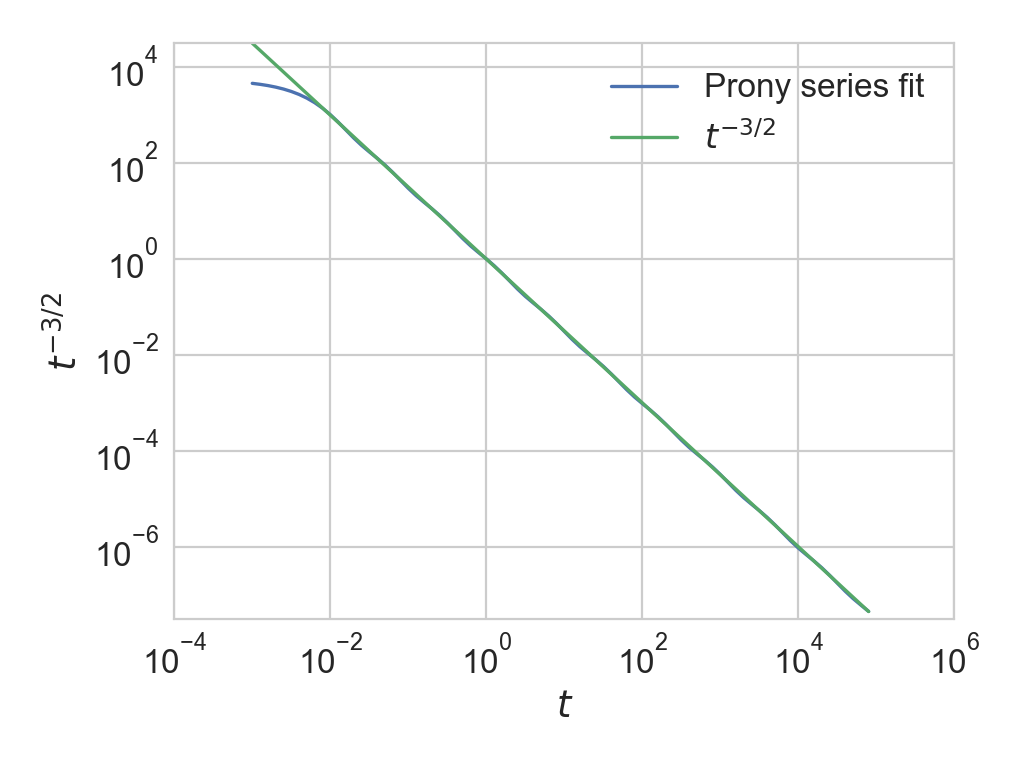

In [29]:
plt.xlabel('$t$')
plt.ylabel('$t^{-3/2}$')

plt.xlim(10.0**(texp_lo-1), 10.0**(texp_hi+1))
plt.ylim(10.0**(-1.5*texp_hi), 10.0**(-1.5*texp_lo))

plt.loglog(t, y, label='Prony series fit')
plt.loglog(t, t**(-1.5), label=r'$t^{-3/2}$')
plt.legend()
plt.tight_layout()

---

---

## Version 1

In [131]:
def f(t, alpha=1.5, N=N, nu0=nu0, b=b, C=C):
    psum = 0
    ib = 1.0/b
    for k in xrange(1, N+1):
        nu0_ibk = nu0*ib**k
        psum += nu0_ibk**alpha * np.exp(-nu0_ibk*t)
    return C*psum

## Version 2

In [4]:
def kth_prony_term(t, k, alpha=1.5, nu0=nu0, b=b):
    return (nu0/b**k)**alpha * np.exp(-nu0*t/b**k)

def prony_sum(t, alpha=1.5, N=N):
    return np.sum([kth_prony_term(t, k, alpha=alpha) for k in xrange(1, N+1)])

def f2(times, alpha=1.5, C=C):
    return np.fromiter((C*prony_sum(t, alpha=alpha) for t in times), np.float)

### Cythonize version 2

## Naive test for equivalence of v1 and v2

In [11]:
t_test = np.array([1.0, 10.0, 100.0])

print 'f  = {}'.format(f(t_test))
print 'f2 = {}'.format(f2(t_test))

f  = [  1.00558568e+00   3.08752246e-02   9.65575074e-04]
f2 = [  1.00558568e+00   3.08752246e-02   9.65575074e-04]


# Timing test

### Custom timing information function

In [59]:
def summarize_timings(p, fac=10.0**6, unit='μs'):
    p_all, p_best, p_worst = fac*np.array(p.all_runs)/p.loops, fac*p.best, fac*p.worst
    print "{0:5.3f} {4:} | {1:5.3f} ± {2:5.3f} {4:}  |  {3:5.3f} {4:} (Worst)".format(p_best, np.mean(p_all), np.std(p_all), p_worst, unit)

## Construct logarithmically spaced times

In [7]:
texp_lo = -3.0
texp_hi = 5.0
logt = np.arange(texp_lo, texp_hi, step=0.1, dtype=np.float64)
t = 10.0**logt

---

### Python Version 1

In [132]:
p0 = %timeit -o -r5 f(t)
summarize_timings(p0)

10000 loops, best of 5: 54.9 µs per loop
54.895 μs | 56.084 ± 0.920 μs  |  148.058 μs (Worst)


### Python Version 2

In [9]:
p0 = %timeit -o -r5 f2(t)
summarize_timings(p0, fac=10.0**3, unit='ms')

100 loops, best of 5: 2.79 ms per loop
3.041 ± 0.249 ms  |  2.791 / 5.283 ms (Best/Worst)


---

In [101]:
texp_lo = -3.0
texp_hi = 5.0
logt = np.arange(texp_lo, texp_hi, step=0.1, dtype=np.float64)
t = 10.0**logt

In [107]:
t = np.array(10.0**logt, dtype=np.float32)

### Cython Version 1.1 (Cythonized Py v1)

In [60]:
%%cython -f -c=-march=native -c=-O3 -c=-funroll-loops -c=-ffast-math
import numpy as np
cimport numpy as np
cimport cython

def c_f1_v1(t, alpha=1.5, N=13, nu0=1000.0, b=5.0, C=1.78167):
    psum = 0
    for k in xrange(1, N+1):
        psum += (nu0/b**k)**alpha * np.exp(-nu0*t/b**k)
    return C*psum

In [61]:
p0 = %timeit -o -r5 c_f1_v1(t)
summarize_timings(p0)

10000 loops, best of 5: 72.1 µs per loop
72.087 μs | 77.582 ± 6.459 μs  |  216.961 μs (Worst)


### Cython Version 1.1.2 (Cythonized Py v1)

In [133]:
%%cython -f -c=-march=native -c=-O3 -c=-funroll-loops -c=-ffast-math
import numpy as np
cimport numpy as np
cimport cython

def c_f1_v1_2(t, alpha=1.5, N=13, nu0=1000.0, b=5.0, C=1.78167):
    psum = 0
    ib = 1.0/b
    for k in xrange(1, N+1):
        nu0_ibk = nu0*ib**k
        psum += nu0_ibk**alpha * np.exp(-nu0_ibk*t)
    return C*psum

In [134]:
p0 = %timeit -o -r5 c_f1_v1_2(t)
summarize_timings(p0)

10000 loops, best of 5: 50.5 µs per loop
50.510 μs | 51.417 ± 0.728 μs  |  170.231 μs (Worst)


### Cython Version 1.1.3 (Cythonized Py v1)

In [110]:
%%cython -f -c=-march=native -c=-O3 -c=-funroll-loops -c=-ffast-math
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp

def c_f1_v1_3(double[::1] t, double alpha=1.5, int N=13, double nu0=1000.0, double b=5.0, double C=1.78167):
    cdef int Nt = t.shape[0]
    cdef double[:,::1] psum = np.zeros((N, Nt))
    cdef double ib = 1.0/b
    cdef double nu0_ibk
    cdef int k, i
    for k in xrange(N):
        nu0_ibk = nu0*ib**(k+1)
        for i in xrange(Nt):
            psum[k,i] = nu0_ibk**alpha * exp(-nu0_ibk*t[i])
    return C*np.sum(psum, axis=0)

In [112]:
p0 = %timeit -o -r5 c_f1_v1_3(t)
summarize_timings(p0)

10000 loops, best of 5: 58.2 µs per loop
58.166 μs | 59.735 ± 0.871 μs  |  164.032 μs (Worst)


---

## Plot Prony series approximation vs. exact solution

In [20]:
texp_lo = -3.0
texp_hi = 5.0
logt = np.arange(texp_lo, texp_hi, step=0.1)
t = 10.0**logt
y = f(t)

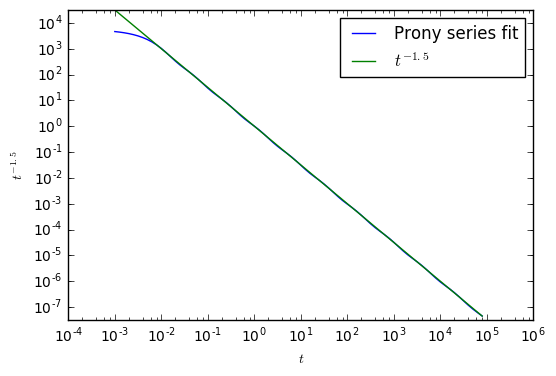

In [81]:
plt.xlabel('$t$')
plt.ylabel('$t^{-1.5}$')

plt.xlim(10.0**(texp_lo-1), 10.0**(texp_hi+1))
plt.ylim(10.0**(-1.5*texp_hi), 10.0**(-1.5*texp_lo))

plt.loglog(t, y, label='Prony series fit')
plt.loglog(t, t**(-1.5), label='$t^{-1.5}$')
plt.legend()

---

## Testing `numpy.random.normal`

In [145]:
locs = np.zeros((6,3))
sigmas = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
# sigmas = np.vstack((sigmas, sigmas, sigmas)).T
thing = np.broadcast(0.0, sigmas)

In [147]:
print locs
print sigmas

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[ 1.  2.  3.  4.  5.  6.]


In [ ]:
np.array([-1,-2,-3])*sigmas

In [138]:
Nsamples = 1000
samples = np.zeros((Nsamples, 6, 3))
for i in xrange(Nsamples):
    samples[i,:,:] = npr.normal(loc=0.0, scale=sigmas)

print samples.mean(axis=0), '\n',  samples.std(axis=0)

[[ 0.0074574   0.02035002  0.02720399]
 [-0.05551709 -0.04346464  0.00720106]
 [-0.04099232 -0.03760146  0.03747643]
 [-0.11567108 -0.1302098   0.09404273]
 [-0.03488596  0.07334248 -0.24619332]
 [ 0.11292146  0.01940827 -0.33240406]] 
[[ 1.00884974  1.01853266  1.01873381]
 [ 1.95480742  1.93583142  2.0266512 ]
 [ 3.02446     2.94326395  2.99313533]
 [ 4.04246208  4.01139029  3.83829018]
 [ 4.89468664  4.98097623  5.1488394 ]
 [ 6.10411348  5.94664274  5.97708606]]


In [139]:
npr.normal(loc=locs, scale=sigmas, size=(6,3))

array([[-1.83956587, -1.05718706,  0.44283952],
       [-0.92567949,  1.73782792,  1.50767768],
       [-1.8925146 ,  5.57067931, -0.57008111],
       [-4.91025822, -6.03199386,  0.0875933 ],
       [-0.51438339,  5.23870963,  3.72960469],
       [-3.7530331 ,  8.20375123,  9.96579042]])

In [149]:
np.broadcast_to(sigmas, (3, 6))

array([[ 1.,  2.,  3.,  4.,  5.,  6.],
       [ 1.,  2.,  3.,  4.,  5.,  6.],
       [ 1.,  2.,  3.,  4.,  5.,  6.]])